In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import PIL
from PIL import Image
import random
import numpy as np

In [2]:
import random

class ATT_Faces(data.Dataset):
    
    def __init__(self,imageFolderDataset,should_invert=False,transform=None):
        self.imageFolderDataset=imageFolderDataset
        self.should_invert=should_invert
        self.transform=transform
    
    def __getitem__(self,idx):
        img0_tuple=random.choice(self.imageFolderDataset.imgs) # tuple of the form (Image_PATH,label)
        same_class=random.choice([True,False]) # Whether image 2 should be in same class or not
        
        if(same_class):
            while True:
                img1_tuple=random.choice(self.imageFolderDataset.imgs)
                if(img0_tuple[1]==img1_tuple[1]):
                    break
        else:
            img1_tuple=random.choice(self.imageFolderDataset.imgs)

        img0=Image.open(img0_tuple[0])
        img1=Image.open(img1_tuple[0])
        img0=img0.convert("L")
        img1=img1.convert("L")
        
        if(self.should_invert):
            img0=PIL.ImageOps.invert(img0)
            img1=PIL.ImageOps.invert(img1)
            
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img0_tuple[1]!=img1_tuple[1])]))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
train_data=ImageFolder("C:/Datasets/AT&T_Faces/train")
test_data=ImageFolder("C:/Datasets/AT&T_Faces/test")

In [4]:
transform=transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_data=ATT_Faces(train_data,transform=transform)
test_data=ATT_Faces(test_data,transform=transform)

In [6]:
train_dataloader=data.DataLoader(train_data,batch_size=4,shuffle=True)
testLoader=data.DataLoader(test_data,batch_size=1,shuffle=True)

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1=nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1,4,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(82432, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )
        
    def forward(self,input1,input2):
        output1=self.forward_once(input1)
        output2=self.forward_once(input2)
        return output1,output2
        
    def forward_once(self,x):
        output=self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output=self.fc1(output)
        return output



In [8]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss Function
    """
    def __init__(self,margin=2.0):
        super().__init__()
        self.margin=margin
    
    def forward(self,output1,output2,label):
        euclidean_distance=F.pairwise_distance(output1,output2)
        loss_contrastive=torch.mean((1-label)*torch.pow(euclidean_distance,2)+
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [9]:
net=SiameseNetwork().cuda()
criterion=ContrastiveLoss().cuda()
optimizer=torch.optim.Adam(net.parameters(),lr=0.0005)

In [10]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=82432, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inpla

In [11]:
loss_history = [] 

In [12]:
for epoch in range(0,50):
    e_loss=0
    count=0
    for i, data in enumerate(train_dataloader,0):
        count+=1
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net.forward(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        e_loss+=loss_contrastive.item()
        loss_contrastive.backward()
        optimizer.step()
    loss_history.append(e_loss/count)
    print(f"Epoch {epoch} Loss:{e_loss/count}")

Epoch 0 Loss:5.5617595337411405
Epoch 1 Loss:2.2232220011052264
Epoch 2 Loss:2.016264788566097
Epoch 3 Loss:1.5851147444017473
Epoch 4 Loss:1.597218430490904
Epoch 5 Loss:1.4148740925455605
Epoch 6 Loss:1.33631012516637
Epoch 7 Loss:1.2584062276347991
Epoch 8 Loss:1.2510029090348112
Epoch 9 Loss:1.1498637901198479
Epoch 10 Loss:1.181177180620932
Epoch 11 Loss:1.2052916826740387
Epoch 12 Loss:1.1507742305596669
Epoch 13 Loss:1.2025348263722595
Epoch 14 Loss:1.2112298319416661
Epoch 15 Loss:1.1776916817311318
Epoch 16 Loss:1.1444203754266102
Epoch 17 Loss:1.1567659525461094
Epoch 18 Loss:1.1473564582486306
Epoch 19 Loss:1.1136251638333003
Epoch 20 Loss:1.2067709183821114
Epoch 21 Loss:1.1344596661867634
Epoch 22 Loss:1.150232159642763
Epoch 23 Loss:1.1683802091947166
Epoch 24 Loss:1.3333436612800886
Epoch 25 Loss:1.1322827372820146
Epoch 26 Loss:1.1241652715590693
Epoch 27 Loss:1.1400332325889218
Epoch 28 Loss:1.0881248170970588
Epoch 29 Loss:1.1129557373382712
Epoch 30 Loss:1.2680481899

In [13]:
import matplotlib.pyplot as plt

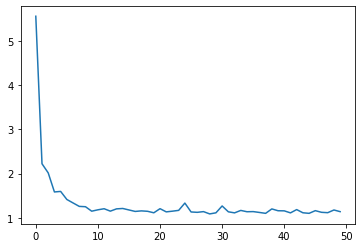

In [14]:
plt.plot(loss_history)

In [15]:
import torchvision

In [16]:
dataiter=iter(testLoader)
x0,x1,label= next(dataiter)

Text(0.5, 1.0, 'Dissimilarity: 0.546999990940094')

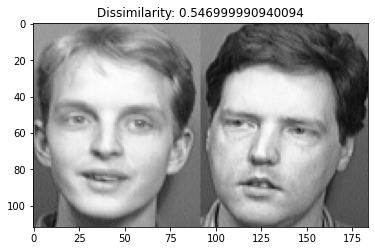

In [17]:
_,x1,label=next(dataiter)
x0.squeeze().shape
output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)
concat=torch.cat((x0.squeeze(),x1.squeeze()),1)
plt.imshow(concat,cmap="gray")
plt.title(f'Dissimilarity: {round(euclidean_distance.cpu().data.numpy()[0],3)}')